In [1]:
from matplotlib import pyplot as plt
import numpy as np  
from scipy import ndimage
import cv2
%config Completer.use_jedi = False

## 2D Projections and roations

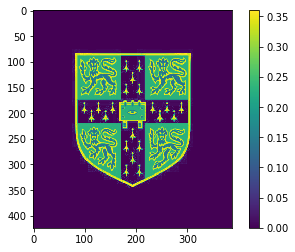

In [2]:
# load image
fpath = r'camb_shield.npy'
im = np.load(fpath)
im = np.max(im) - im
im = np.pad(im,75,mode='constant')
plt.imshow(im)
im.shape
plt.colorbar()

In [3]:
def rotate(im,a=0):
    return ndimage.rotate(im,a,order=1,reshape=False)

def project(im,a=0):
    if a != 0:
        imr = rotate(im,a)
    if a == 0:
        imr = im
    return np.sum(imr,axis=0)

0.0
22.5
45.0
67.5
90.0


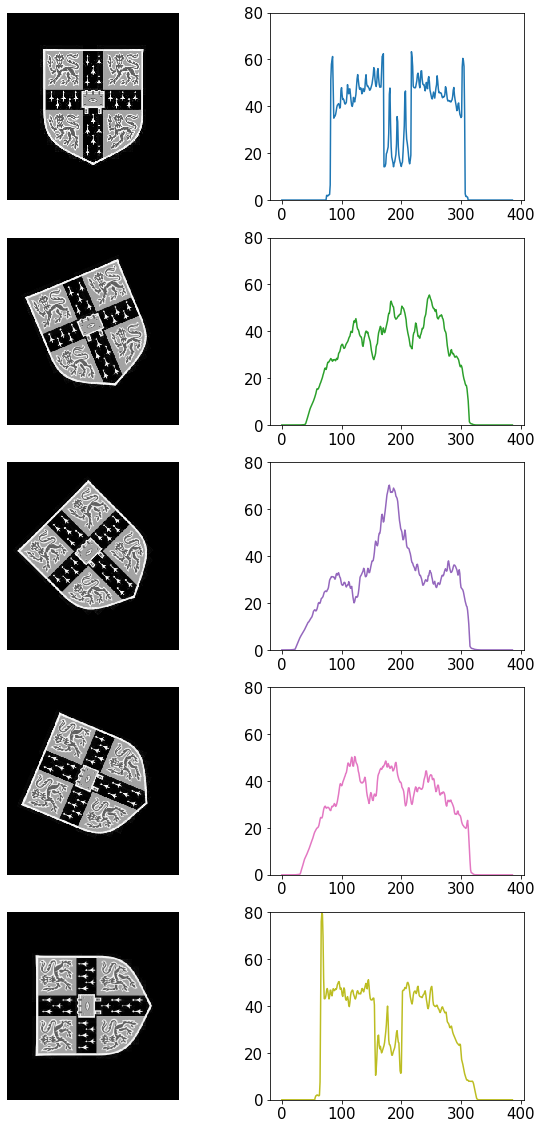

In [15]:
# plot projections
import matplotlib
#cmap = matplotlib
cmap = matplotlib.cm.get_cmap('tab10')

angles = np.linspace(0,90,num=5)
f,axs = plt.subplots(nrows=5,ncols=2,figsize=(10,20))
for i, a in enumerate(angles):
    imr = rotate(im,a=a)
    imp = project(imr)
    print(a)
    axs[i,0].imshow(imr,cmap='gray')
    axs[i,0].axis('off')
    c=cmap(i/5)
    axs[i,1].plot(imp,c=c)
    axs[i,1].set_ylim([0,80])

Text(0, 0.5, 'Projection angle \n (ccw from vertical) \n / degrees')

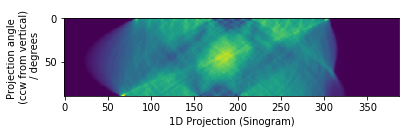

In [14]:
# plot sinogram
ps = []
for a in range(90):
    p = project(im,a)
    ps.append(p)
plt.imshow(ps)
plt.xlabel('1D Projection (Sinogram)')
plt.ylabel('Projection angle \n (ccw from vertical) \n / degrees')

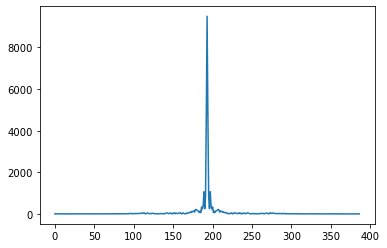

In [7]:
p = project(im,30)

fp = np.fft.fft(p)
fp = np.fft.fftshift(fp)
plt.plot(abs(fp))

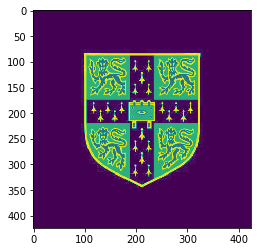

In [15]:
import copy
im2 = copy.deepcopy(im)
im2 = np.pad(im2,((0,0),(18,19)),'constant')
np.shape(im2)
plt.imshow(im2)

In [17]:
angles = np.linspace(0,90,num=5)
N = 1000
d = 424
n = 424
centre = int(N/2)
rpx = d/n
fpx = 1/rpx / N
width = 1/d
width_i = 10#width/fpx
final = np.zeros((N,N))

for a in angles:
    # project image
    p = project(im2,a)
    fp = np.fft.fft(p)
    fp = abs(np.fft.fftshift(fp))
    # reshape projection to desired shape
    p_resize = cv2.resize(fp,dsize=(int(width_i/2)*2,N))

    fs = np.zeros((N,N))

    # central slice becomes projection data


    fs[:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize
    fsr = rotate(fs,a)
    final += fsr

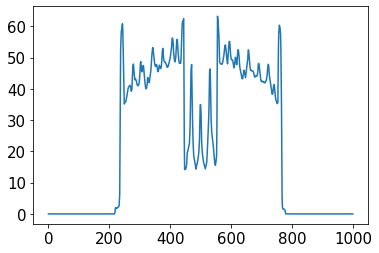

In [105]:
p=project(im2,0)
p_resize = cv2.resize(p,dsize=(int(width_i/2)*2,N))
plt.plot(p_resize[:,0])

C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


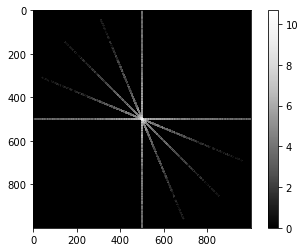

In [18]:
res = final
res = np.log(res)
res[np.isneginf(res)]= 0
plt.imshow(res,cmap='Greys_r',vmin=0)
plt.colorbar()

(-0.5, 999.5, 999.5, -0.5)

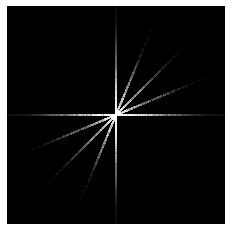

In [27]:
plt.imshow(hamming_2d(np.flipud(res).T),cmap='Greys_r',vmin=0,vmax=6)
plt.axis('off')
#plt.colorbar()

(-0.5, 423.5, 423.5, -0.5)

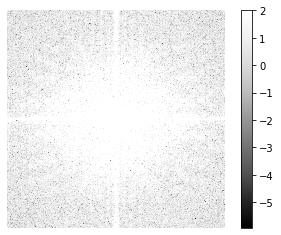

In [54]:
%matplotlib inline
fft =np.fft.fft2(hamming_2d(im2))
fft = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(fft)),cmap='Greys_r',vmax=2)
plt.colorbar()
plt.axis('off')

## Plot Fourier slices

In [28]:
# plot fourier space slices for given object size, sampling rate, max extent, and single tilt range
def plot_slices2(d=100,n=200,lmin=1,num=30, save_path = False,amax=90,im = None):
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, >10 is good enough
    # lmin is real space width of pixel at highest res of interest
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.gca()

    # Create uniform image of ones
    if type(im) == type(None):
        im = np.ones((n,n))
    
    # angle projection range
    angles = np.linspace(-amax,amax,num=num)
    
    # width of image
    n = np.shape(im)[1]
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width
    N = 1000
    final = np.zeros((N,N))
    
    centre = int(N/2)
    
    rpx = d/n
    fpx = 1/rpx / N
    width = 1/d
    width_i = width/fpx
    print('--%.1f-- should be >=10, else your FS display resolution is not high enough)' % width_i)
    print(int(width_i/2)*2,width_i)
    
    # loop over angles and add each projection to fourier image
    for a in angles:
        # project image
        p = project(im,a)
        # reshape projection to desired shape
        p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
        
        fs = np.zeros((N,N))
        
        # central slice becomes projection data
        
        
        fs[centre-int(width_i/2):centre+int(width_i/2),:] = p_resize
        fsr = rotate(fs,a)
        final += fsr

    # display width no. at desired res in FS
    n_fdw = 1/lmin / fpx
    missing = int(n_fdw-N)
        
#     #pixel width real space
#     px_im = d/n
#     #pixel width in fourier space
#     px_ft = 1/d #1/(n*px_im)
    #Total number of pixels needed for highest res
   # N_res = 1/(lmin*px_ft)#1/(px_im*px_ft)
    # missing pixels in Fourier space
    #missing = int((N-n)/2)
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)],'constant')
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    #Crowther
    fmax = num/(np.pi * d)
    print('Crowther:',fmax)

    plt.imshow(final,vmax=1e-5,cmap='Greys_r',extent=extent)
    c = plt.Circle([0,0],radius=fmax,color='r',fill=False,linestyle='--')
    ax.add_patch(c)
    plt.xlabel('k$_x$ / nm$^{-1}$')
    plt.ylabel('k$_y$ / nm$^{-1}$')
    plt.title('Size: %i nm x %i nm, Sampling: %i x %i, \n Pixel width: %.2f nm, %i projections' % (d,d,n,n,d/n,num))
    
    if save_path != False:
        plt.savefig(save_path)
        
    return final

--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
Crowther: 0.015915494309189534


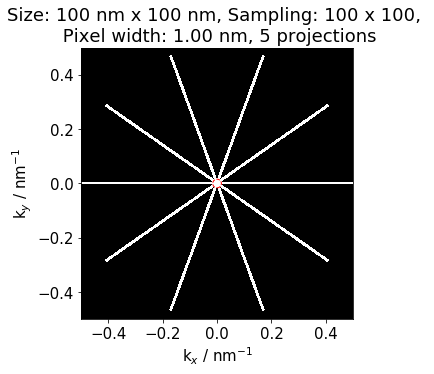

In [6]:
%matplotlib inline
fim = plot_slices2(n=100,amax=70,num=5)

## Reduced Crowther

In [189]:


d = 100
n = 100
N = 1000

def reduced_crowther(fim2,d=100,n=100,N=1000):
    dim = int(np.shape(fim2)[0]/2)
    rpx = d/n
    fpx = 1/rpx / N
    crow2 = 0
    class GetOutOfLoop( Exception ):
        pass

    try:
        for rad_px in range(1,dim):
            for i in range(rad_px):
                for j in range(rad_px):
                    if i**2 + j**2 < rad_px**2:
                        if fim2[dim+i,dim+j] == 1 and fim2[dim-i,dim-j] == 1 and fim2[dim+i,dim-j] == 1 and fim2[dim-i,dim+j] == 1:
                            pass
                        else:
                            #print(rad_px,i,j)#,fim2[dim+i,dim+j])
                            crow2 = 1/(rad_px*fpx)
                            #print(dim+i,dim+j)
                            raise getOutOfLoop
    except:
        pass
    return crow2

reduced_crowther(fim2)

55.55555555555555

In [197]:
# slices in FS
n=100
d=100

all_ds = []
for num in [10,20,30,40,50,60,70]:
    ds = []
    for amax in [10,20,30,40,50,60,70,80,90]:
        fim = plot_slices2(n=100,d=100,amax=amax,num=num)
        plt.close()
        #binarise
        t = 1e-8
        fim2 = (fim > t).astype(np.int_)
        d = reduced_crowther(fim2,d=100,n=100,N=1000)
        ds.append(d)
    all_ds.append(ds)

--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not high enough)
10 10.0
--10.0-- should be >=10, else your FS display resolution is not h

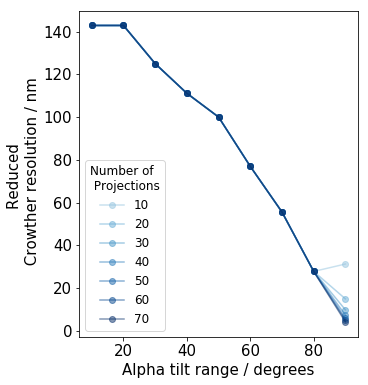

In [236]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Blues')
plt.figure(figsize=(5,6))
for i, num in enumerate([10,20,30,40,50,60,70]):
    c = cmap((i+1)/7*.7+.3)
    plt.plot([10,20,30,40,50,60,70,80,90],all_ds[i],'o-',label=num,color=c,alpha=.5)
    plt.xlabel('Alpha tilt range / degrees')
    plt.ylabel('Reduced \n Crowther resolution / nm')
    
leg = plt.legend(title='Number of \n Projections',fontsize=12,loc='lower left')
leg.get_title().set_fontsize('12')

## Plot Fourier transforms

In [333]:
# make a gif
import imageio

#sizes = np.linspace(15,500,num=30)
#nums = np.linspace(1,100,num=30)
res = np.linspace(25,500,num=30)
fpaths = []
for x in res:
    x = int(x)
    fpath = r'Output_Data/slices/res/%i.png' % x
    plot_slices(n=x,save_path=fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'Output_Data/slices/res.gif',images)

In [21]:
def sin_im(xFreq=10,yFreq=0,lims=[100,50],scales=[1,1]):
    """ Note that the frequency is relative to the size of the image
    i.e. xfreq 10 for an image 100 nm wide will peak at 0.1 nm^-1
    i.e. it will fit xfreq oscillations into lim space"""
    xFreq*=1/lims[0]#scales[0]
    yFreq*=1/lims[1]#scales[1]
    x = np.linspace(0, lims[0], int(lims[0]/scales[0]))
    y = np.linspace(0, lims[1], int(lims[1]/scales[1]))
    X,Y = np.meshgrid(x,y)
    im = np.exp(2j * np.pi * Y * yFreq) * np.exp(2j * np.pi * X * xFreq)
    return np.real(im)
    
def hamming_2d(im):
    s = np.shape(im)
    h1 = np.hamming(s[0])
    h2 = np.hamming(s[1])
    ham2d = (np.outer(h1,h2))
    return im*ham2d


# plt.show()

# f,axs = plt.subplots(nrows=3,ncols=3)
# for i in range(3):
#     for j in range(3):
#         axs[i,j].imshow(im)
#         axs[i,j].axis('off')
# #plt.tight_layout()
# plt.subplots_adjust(wspace=0.08, hspace=-0.5)

(-0.5, 99.5, 99.5, -0.5)

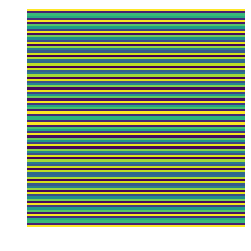

In [358]:
# im = np.ones((100,100))
# im = hamming_2d(im)
im = sin_im(xFreq=0,yFreq=0.4*100,lims=[100,100],scales=[1,1])
plt.imshow(im)
plt.axis('off')

In [335]:
def plot_FFT(im,scale=1,truncate=None,log=False,ax=None,ds=None,ns=None, lmin = None):
    """ Calculate and plot the FFt of an image
    To see fine details, try truncating the maximum value,
    plotting in log form, and scaling the data."""
    if ax==None:
        fig = plt.figure()
        ax = plt.gca()
    # https://stackoverflow.com/questions/39760962/how-to-normalise-a-2d-fft-plot-to-the-right-frequency-matlab
    F = np.fft.fft2(im)
    
    # A peculiarity of the DFT is that frequencies increase up to N/2
    # And then decrease from N/2 to N. This is a 'reflection' and is
    # to do with Nyquist sampling frequencies. We instead shift
    # such that the low frequencies are the in centre and we see a
    # range from -N/2 to N/2
    # We can do this because DFTs assume periodicity of the signal
    F_shift = np.fft.fftshift(F)
    
    # We want the amplitude spectrum which is the magnitude
    # we may also which to scale this to see more clearly
    F_shift_abs = abs(F_shift) * scale
    
    # showing on a log scale can show features more clearly
    if log == True:
        F_shift_abs = np.log(abs(F_shift)) * scale
    
    # truncating the maximum value can show more clearly
    if truncate == None:
        truncate = np.max(F_shift_abs)
        
    # establish spatial frequency axes
    
    # get image length d in nm and number of pixels n
    if ds == None:
        dy,dx = np.shape(im) # image length in nm
        nx,ny = dx,dy # number of samples along length
        
        ds,ns = [dx,dy], [nx,ny]
    dx,dy = ds
    nx,ny = ns  
    # get pixel width in real space in nm
    l_im_x = dx/nx
    l_im_y = dy/ny
    
    fx = 1/l_im_x * np.arange(-nx/2,nx/2-1)/nx
    fy = 1/l_im_y * np.arange(-ny/2,ny/2-1)/ny
    
    # get MINIMUM pixel width in real space in nm (at highst res)
    if lmin == None:
        lmin = [l_px_x,l_px_y]
        
    l_im_min_x,l_im_min_y = lmin
    
    # calculate pixel width in fourier space
    l_ft_x = 1/(l_im_x * nx) 
    l_ft_y = 1/(l_im_y * ny) 
    
    # calculate total number of pixels needed to reach highest resolution in FT
    Nx = 1/(l_im_min_x*l_ft_x)
    Ny = 1/(l_im_min_y*l_ft_y)
    
    # missing pixels
    missing_x = Nx - nx
    missing_y = Ny - ny
    
    fft = np.pad(F_shift_abs,[(int(missing_y/2), int(missing_y/2)), (int(missing_x/2), int(missing_x/2))])
    
    # left right bottom top
    #extent = [np.min(fx),np.max(fx),np.min(fy),np.max(fy)]
    #extent = [-1/l_im_x/2, 1/l_im_x/2, -1/l_im_y/2,1/l_im_y/2]
    extent = [-1/l_im_min_x/2,1/l_im_min_x/2,-1/l_im_min_x/2,1/l_im_min_x/2] 
    
    #print(l_ft_x,l_ft_y)
    imshow = ax.imshow(fft,vmax=truncate,cmap='Greys_r',extent=extent)
    plt.colorbar(imshow,fraction=0.046, pad=0.04)
    ax.set_title('Fourier space',fontsize=20)
    
    ax.set_xlabel('k$_x$ / nm$^{-1}$',fontsize=15)
    ax.set_ylabel('k$_y$ / nm$^{-1}$',fontsize=15)

In [181]:
%matplotlib
%matplotlib qt

Using matplotlib backend: Qt5Agg


Image dimensions: 287 x 84 nm 	 Image sampling: 212 x 76


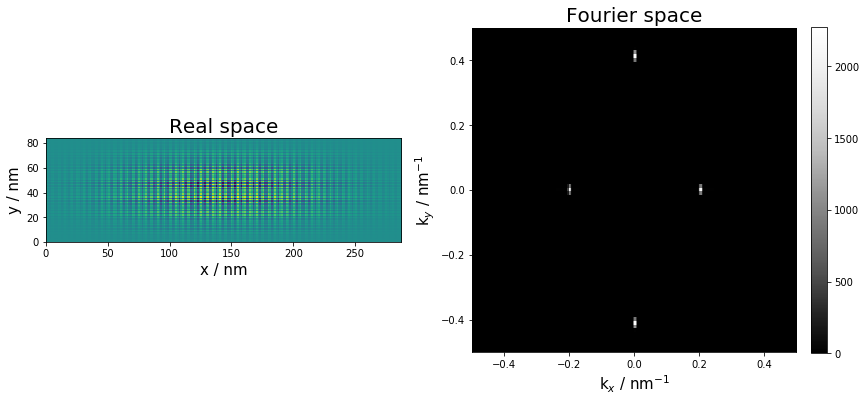

In [343]:
%matplotlib inline

# max sampling = minimum pixel length in nm
lmin = 1

# image lengths in nm
dx = 287
dy = 84

# image sampling no.s
nx = 212#dx/(lmin*1)
ny = 76#dy/(lmin*1)

# Create image
# Freq is f * d since Freq is the number of oscillations over the image
# so for a frequency of f, you need f*d oscillations per image 
im1 = sin_im(xFreq=.2*dx,yFreq=0*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im2 = sin_im(xFreq=0*dx,yFreq=.4*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im = im1+im2
im = hamming_2d(im)

# Plot image
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ly,lx = np.shape(im)
imshow1 = axs[0].imshow(im,extent=[0,dx,0,dy],cmap='viridis')
axs[0].set_title('Real space',fontsize=20)
axs[0].set_xlabel('x / nm',fontsize=15)
axs[0].set_ylabel('y / nm',fontsize=15)

# Plot FFT
plot_FFT(im,scale=1,truncate = None, log=False,ax=axs[1],ds=[dx,dy],ns=[nx,ny], lmin=[lmin,lmin])

print('Image dimensions:',dx,'x',dy,'nm \t Image sampling: %i x %i' %(nx,ny))

## Eigendecomposition

In [4]:
import multi_axis
import astra       

In [12]:
angles = multi_axis.generate_angles(n_tilt=19,alpha=45)
vectors = multi_axis.generate_vectors(angles)

raw_data = np.ones((30,19,30))

In [23]:
# 3D
#proj_geom = astra.create_proj_geom('parallel3d_vec',np.shape(raw_data)[0],np.shape(raw_data)[2],np.array(vectors))
proj_geom = astra.create_proj_geom('parallel3d',1,1,np.shape(raw_data)[0],np.shape(raw_data)[2],np.linspace(-45,45,19)*np.pi/180)

vol_geom = astra.creators.create_vol_geom(np.shape(raw_data)[0], np.shape(raw_data)[0],np.shape(raw_data)[2]) 

proj = astra.data3d.create('-proj3d', proj_geom, 0)
proj_id = astra.create_projector('cuda3d', proj, vol_geom) 

matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)

Exception: Error creating Projector3D.

In [96]:
astra.projector.clear()
# low res part (voxels of 4x4x4)
#Y, X, Z, minx, maxx, miny, maxy, minz, maxz
vol_geom1 = astra.create_vol_geom(30,30,30)

# Split the output in two parts as well, for demonstration purposes
angles1 = np.linspace(-45, 45, 19) * np.pi/2

#'parallel3d', detector_spacing_x, detector_spacing_y, det_row_count, det_col_count, angles
proj_geom1 = astra.create_proj_geom('parallel3d', 1.0, 1.0, 30, 30, angles1)

# Create a simple hollow cube phantom
cube1 = np.zeros((30,30,30))
cube1[4:28,4:28,4:16] = 1

vol1 = astra.data3d.create('-vol', vol_geom1, cube1)

proj1 = astra.data3d.create('-proj3d', proj_geom1, 0)

# The actual geometries don't matter for this composite FP/BP case
#projector = astra.create_projector('linear3d', proj_geom1, vol_geom1)
#cfg = astra.astra_dict({'type':'linear3d', 'ProjectionGeometry':proj_geom1, 'VolumeGeometry':vol_geom1})
proj_type = 'cuda3d'
cfg = astra.astra_dict(proj_type)
cfg['ProjectionGeometry'] = proj_geom1
cfg['VolumeGeometry'] = vol_geom1
projector = astra.projector3d.create(cfg)
projector
#a = astra.data3d.get(proj1)
matrix_id = astra.projector3d.splat(projector,0,0)
matrix_id
#W = astra.matrix.get(matrix_id)
#np.shape(a)

Exception: Not yet implemented

In [66]:
# low res part (voxels of 4x4x4)
#Y, X, Z, minx, maxx, miny, maxy, minz, maxz
vol_geom1 = astra.create_vol_geom(32, 16, 32, -64, 0, -64, 64, -64, 64)


# Split the output in two parts as well, for demonstration purposes
angles1 = np.linspace(-45, 45, 19) * np.pi/2

#'parallel3d', detector_spacing_x, detector_spacing_y, det_row_count, det_col_count, angles
proj_geom1 = astra.create_proj_geom('parallel3d', 1.0, 1.0, 128, 192, angles1)

# Create a simple hollow cube phantom
cube1 = np.zeros((32,32,16))
cube1[4:28,4:28,4:16] = 1

vol1 = astra.data3d.create('-vol', vol_geom1, cube1)

proj1 = astra.data3d.create('-proj3d', proj_geom1, 0)

# The actual geometries don't matter for this composite FP/BP case
projector = astra.create_projector('cuda3d', proj_geom1, vol_geom1)

In [515]:
np.shape(W)

(1500, 400)

In [123]:
def hacky_res_shit_2d(amax,n_tilt,n,d = 100):
    # calculate projection matrix
    proj_geom = astra.create_proj_geom('parallel',1,n,np.linspace(-amax,amax,n)*np.pi/180) 
    vol_geom = astra.creators.create_vol_geom(n,n) 
    proj_id = astra.create_projector('line', proj_geom, vol_geom) 
    matrix_id = astra.projector.matrix(proj_id) 
    W = astra.matrix.get(matrix_id)
    
    # calculate eigenvalues of normal matrix
    N = np.matmul(W.A.T,W.A)
    ev = np.linalg.eig(N)[0]
    ev = np.reshape(ev,(n,n),order='F')
    
    # find where value of 1/ev exceeds 1
    imbin = (1/np.abs(ev) > 1).astype(np.int_)
    
    # find index where >1/3 of data is exceeding 1
    s = np.sum(imbin,axis=0)
    imax = np.where(s>np.shape(imbin)[0]/3)[0][0]
    print(imax)
    
    # plot if you want
    plt.figure()
    plt.imshow(1/np.abs(ev),vmax=1,extent=[1,n,1,n])
    plt.plot([imax,imax],[1,n],'--',color='blue',linewidth=2)
    
    plt.figure()
    plt.plot(np.arange(1,n+1),1/np.sum(ev,axis=0),'-o')
    plt.ylim([0,1])
    
    # convert to a resolution
    max_rad = ((1/d)*(n/2)) * imax/(n)
    
    # plot resolution
    plt.figure()
    plot_slices2(n=n,amax=amax,num=n_tilt,d=n)
    c = plt.Circle([0,0],radius=((1/d)*(n/2)) * 15/(n),color='blue',fill=False,linewidth=2,linestyle='--')
    ax = plt.gca()
    ax.add_patch(c)
    
    return max_rad

19
--33.3-- should be >=10, else your FS display resolution is not high enough)
32 33.333333333333336
Crowther: 0.20159626124973412


0.095000000000000001

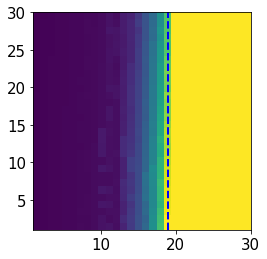

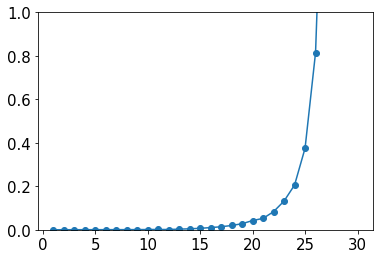

<Figure size 432x288 with 0 Axes>

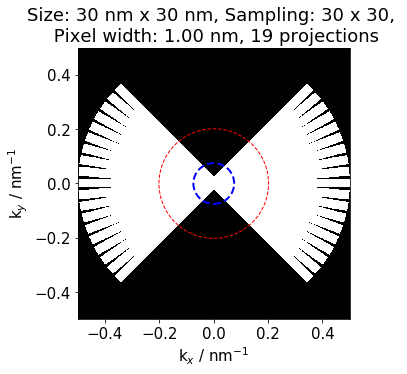

In [126]:
hacky_res_shit_2d(45,19,30)

In [57]:
# 2D
proj_geom = astra.create_proj_geom('parallel',1,15,np.linspace(-45,45,19)*np.pi/180) 
vol_geom = astra.creators.create_vol_geom(20,20) 
proj_id = astra.create_projector('line', proj_geom, vol_geom) 
matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)
np.shape(W)

(285, 400)

(-0.5, 399.5, 284.5, -0.5)

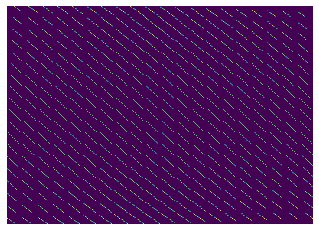

In [58]:
plt.imshow(W.A)
plt.axis('off')

(-0.5, 19.5, 19.5, -0.5)

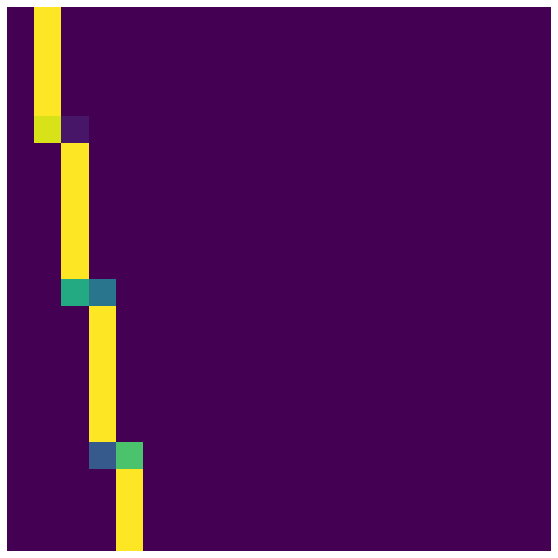

In [59]:
plt.figure(figsize=(16,10))
plt.imshow(W[15+5*30].A.reshape(20,20))
plt.axis('off')


In [60]:
N = np.matmul(W.A.T,W.A)

In [61]:
N_inv = np.linalg.inv(N)

In [62]:
ev = np.linalg.eig(N)[0] # slow took about 10 minutes

In [64]:
ev2 = np.reshape(ev,(20,20),order='C')

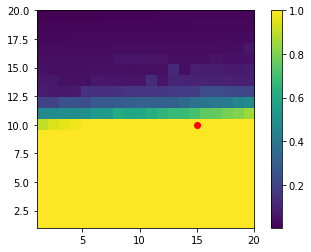

In [65]:
1/ev2
#plt.imshow(np.log10(abs(ev2)),vmin=0)
plt.imshow(1/np.abs(ev2),vmax=1,extent=[1,20,1,20])
plt.colorbar()
plt.plot([15],[10],'ro')

(-0.1, 1.1)

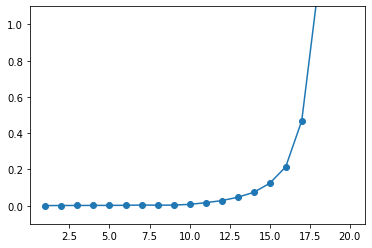

In [34]:
plt.plot(np.arange(1,21),1/np.sum(ev2,axis=1),'-o')
plt.ylim([-0.1,1.1])

25

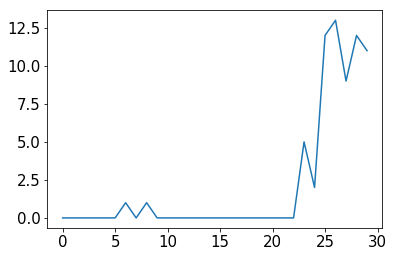

In [485]:
import scipy
im = np.sum(1/np.abs(ev2),axis=0)
imbin = (1/np.abs(ev2) > 1).astype(np.int_)
s = np.sum(imbin,axis=0)
plt.plot(s)
np.where(s>np.shape(imbin)[0]/3)[0][0]

--5.0-- should be >=10, else your FS display resolution is not high enough)
4 5.0


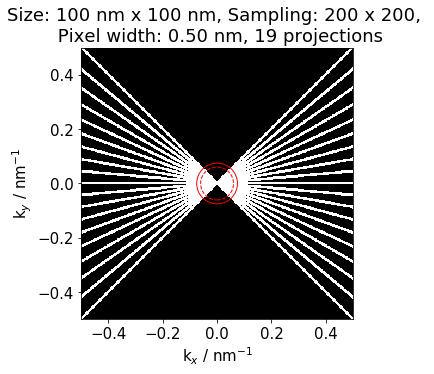

In [510]:
%matplotlib inline
n = 200
plot_slices2(n=n,amax=45,num=19)
d = 100

c = plt.Circle([0,0],radius=((1/d)*(n/2)) * 15/(n),color='r',fill=False)
ax = plt.gca()
ax.add_patch(c)


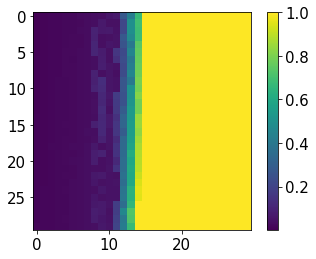

In [83]:
amax = 45 # +- alpha tilt range
ntilt = 19 # number of projections
ndet = 30 # number of detector pixels

# Define tilt series angles
angles = np.linspace(-amax,amax,ntilt)*np.pi/180

# calculate projection matrix
proj_geom = astra.create_proj_geom('parallel',1,ndet,angles) 
vol_geom = astra.creators.create_vol_geom(ndet,ndet) 
proj_id = astra.create_projector('line', proj_geom, vol_geom) 
matrix_id = astra.projector.matrix(proj_id) 
W = astra.matrix.get(matrix_id)

# calculate normal matrix
N = np.matmul(W.A.T,W.A)

# calculate eigenvalues of normal matrix
ev = np.linalg.eig(N)[0]

# shape eigenvalues into a square matrix
ev = np.reshape(ev,(ndet,ndet),order='F')

# view '1/eigenvalue', with cutoff above 1
plt.imshow(1/np.abs(ev),vmax=1)
plt.colorbar()

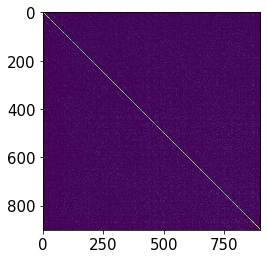

In [98]:
plt.figure()
EV = np.linalg.eig(N)[1]

rm = np.matmul(EV,EV.T)
plt.imshow(abs(rm))

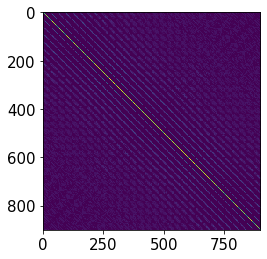

In [81]:
plt.imshow(N)

## Code for Laura's book...

In [141]:
def new_guess(i,letter,guess):
    current_guess = guess[:i] + letter + guess[i + 1:]
    return current_guess

In [149]:
guess = 'D7V5ZM6F8N614E2VQU'
all_guesses = []
for l2 in ['V','W']:
    current_guess = new_guess(2,l2,guess)
    for l3 in ['5','S','3']: # 8 6
        current_guess = new_guess(3,l3,current_guess)
        for l4 in ['Z','7']:
            current_guess = new_guess(4,l4,current_guess)
            for l10 in ['6','8']:
                current_guess = new_guess(10,l10,current_guess)
                all_guesses.append(current_guess)

In [151]:
all_guesses

['D7V5ZM6F8N614E2VQU',
 'D7V5ZM6F8N814E2VQU',
 'D7V57M6F8N614E2VQU',
 'D7V57M6F8N814E2VQU',
 'D7VSZM6F8N614E2VQU',
 'D7VSZM6F8N814E2VQU',
 'D7VS7M6F8N614E2VQU',
 'D7VS7M6F8N814E2VQU',
 'D7V3ZM6F8N614E2VQU',
 'D7V3ZM6F8N814E2VQU',
 'D7V37M6F8N614E2VQU',
 'D7V37M6F8N814E2VQU',
 'D7W5ZM6F8N614E2VQU',
 'D7W5ZM6F8N814E2VQU',
 'D7W57M6F8N614E2VQU',
 'D7W57M6F8N814E2VQU',
 'D7WSZM6F8N614E2VQU',
 'D7WSZM6F8N814E2VQU',
 'D7WS7M6F8N614E2VQU',
 'D7WS7M6F8N814E2VQU',
 'D7W3ZM6F8N614E2VQU',
 'D7W3ZM6F8N814E2VQU',
 'D7W37M6F8N614E2VQU',
 'D7W37M6F8N814E2VQU']

## 3D Fourier space orthoslice plotting

In [253]:
import copy
def swap_cols(arr, frm, to):
    A = copy.deepcopy(arr)
    #arr2[:,[frm, to]] = arr2[:,[to, frm]]
    #A.T[[0, 1]] = A.T[[1, 0]]
    A = np.transpose(A,axes=(1,0,2))
    return A

In [79]:
def plot_slices3D(angles, d=100,n=100,lmin=1):
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, >10 is good enough
    # lmin is real space width of pixel at highest res of interest
    # d is width of image in nm
    # n is number of pixels across image in one row (assumed square)
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.gca()

    # Create uniform volume of ones
    vol = np.ones((n,n,n))
    
    # angle projection range
    
    # width of volume
    n = np.shape(vol)[1]
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width
    N = 200
    final = np.zeros((N,N,N))
    
    centre = int(N/2)
    
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
    width = 1/d # fourier space slice width
    width_i = width/fpx # number of fourier space pixels needed to represent slice width
    print('--%.1f-- should be >=10, else your FS display resolution is not high enough)' % width_i)
    print(int(width_i/2)*2,width_i)
    
    # project volume at each angle
    proj = multi_axis.generate_proj_data(vol,angles)
    proj = swap_cols(proj,1,0)
    
    print('projection finished')
    # loop over angles and add each projection to fourier image
    for i,a in enumerate(angles):
        print('i')
        print('resizing')
        # get projected image
        p = proj[i].reshape((n,n,1))
        
        # reshape projection to desired shape
        #p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
        p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d
        print('rotating')
        fs = np.zeros((N,N,N))
        
        # central slice becomes projection data
        fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize
        
        # rotate to final position - this is quite slow - might be worth trying to speed up
        fsr = multi_axis.rotate_bulk(fs,a[0],a[1],a[2])
        final += fsr
        
    return final

    #l

--2.0-- should be >=10, else your FS display resolution is not high enough)
2 2.0
projection finished
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating
i
resizing
rotating


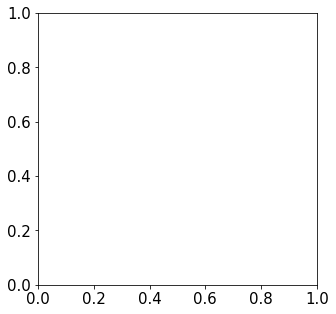

In [80]:
final = plot_slices3D(angles)

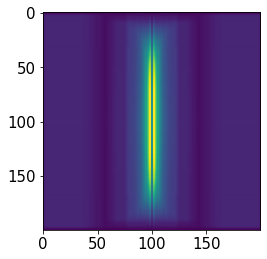

In [96]:
plt.imshow(final[:,:,102])

In [196]:
def plot_3d_slices(vol,plane = 'xz',i_slice=None,d=100,n=100,lmin=1, save_path = False,ax=None):
    if i_slice == None:
        i_slice = int(np.shape(vol)[0]/2)
        
    if plane == 'xy':
        final = vol[:,:,i_slice]
        
    if plane == 'xz':
        final = vol[:,i_slice,:]
        
    if plane == 'yz':
        final = vol[i_slice,:,:]
        
    if ax == None:
        fig,ax = plt.subplots()
        
    N = 200    
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
        
#display width no. at desired res in FS
    n_fdw = 1/lmin / fpx
    missing = int(n_fdw-N)
        
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)],'constant')
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    #Crowther
#     fmax = num/(np.pi * d)
#     print('Crowther:',fmax)

    ax.imshow(final,cmap='Greys_r',extent=extent,vmax=0.01)
#     c = plt.Circle([0,0],radius=fmax,color='r',fill=False,linestyle='--')
#     ax.add_patch(c)
    ax.set_xlabel('k$_x$ / nm$^{-1}$')
    ax.set_ylabel('k$_y$ / nm$^{-1}$')
#    plt.title('Size: %i nm x %i nm, Sampling: %i x %i, \n Pixel width: %.2f nm, %i projections' % (d,d,n,n,d/n,num))
    
    if save_path != False:
        plt.savefig(save_path)

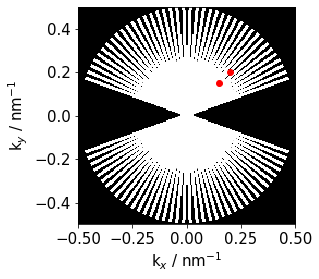

In [359]:
plot_3d_slices(final,plane='yz',i_slice=100,d=100)
plt.plot([0.15,0.2],[0.15,0.2],'ro')

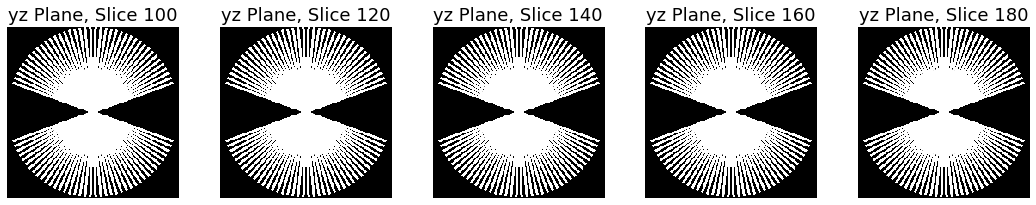

In [203]:
fig,axs = plt.subplots(ncols=5,figsize=(15,3))
plane = 'yz'
for i,i_slice in enumerate([100,120,140,160,180]):
    plot_3d_slices(final,plane=plane,i_slice=i_slice,d=100,ax=axs[i])
    axs[i].axis('off')
    axs[i].set_title(r'%s Plane, Slice %i' % (plane, i_slice))

plt.tight_layout()

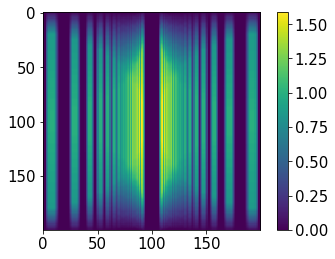

In [252]:
plt.imshow(final[:,:,120],)
plt.colorbar()
#final[:,105,120]

In [21]:
P = np.ones((100,100,100))
angles = multi_axis.generate_angles()
proj = multi_axis.generate_proj_data(P,angles)

In [187]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
s = 2
ax.voxels(final[::s,::s,::s], edgecolor=(1,1,1,0.2),alpha=.2)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000019876AC76A8> (for post_execute):


KeyboardInterrupt: 

In [224]:
np.shape(np.transpose(points))

(3639832, 3)

## Plot Fourier space in 3D view

In [549]:
# 3d plot
import open3d as o3d
s=3 # set number of voxels to skip (increase speed)

# Convert grid to point cloud
points = np.transpose(np.where(final[::s,::s,::s]>0))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(np.zeros_like(points)) # make points all black
# load point cloud as voxel grid
#voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=1)

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector((np.array(inside)+100)*66/200)
pcd2.colors = o3d.utility.Vector3dVector(np.ones_like(points)*.5) # make points all black

# Plot
o3d.visualization.draw_geometries([pcd,pcd2])
# (Use + - buttons to increase/decrase point size interactively)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [547]:
90*fpx

0.45

## 3D directional metric

In [255]:
from grispy import GriSPy # for finding points at given radius fast

In [693]:
def prepare_radius_search(final):
    #crd = np.transpose(np.where(final)) # coordinates of points in volume
    crd = np.transpose(np.where(final>-10))
    gsp = GriSPy(crd)
    n = np.shape(final)[0]
    c = int(n/2)
    centres = np.array([[c,c,c]])
    
    return gsp, crd, centres

def shell_neighbours(gsp,centres,lower_radii,rad_range=1):
    upper_radii = lower_radii+rad_range
    shell_dist, shell_ind = gsp.shell_neighbors(
        centres,
        distance_lower_bound=lower_radii,
        distance_upper_bound=upper_radii
    )
    
    return shell_ind

def data_completeness_ratio(shell_ind,crd,thresh=1):
    full = 0
    empty = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = final[ind[0],ind[1],ind[2]]
        #print(val)
        if val > thresh:
            full += 1
            filled_inds.append(ind)
        else:
            empty += 1
    return full/(empty+full), filled_inds

def data_completeness_ratio_vec(shell_ind,crd,f,thresh=1):
    vals = 0
    tots = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = f[ind[0],ind[1],ind[2]]
        #print(val)
        vals += val
        tots +=1
    return vals/tots, filled_inds

In [506]:
gsp,crd,centres = prepare_radius_search(final)
shell_ind = shell_neighbours(gsp,centres,35)
dc_ratio,filled_inds = data_completeness_ratio(shell_ind,crd)

In [712]:
gsp,crd,centres = prepare_radius_search(fz)
shell_ind = shell_neighbours(gsp,centres,35)
dc_ratio,filled_inds = data_completeness_ratio_vec(shell_ind,crd,fz)
dc_ratio

0.49541481506048735

In [544]:
shell_ind = shell_neighbours(gsp,centres,90)
dc_ratio,filled_inds = data_completeness_ratio(shell_ind,crd)

In [713]:
rats = []
for i in range(2,100):
    shell_ind = shell_neighbours(gsp,centres,i)
    #dc_ratio,_ = data_completeness_ratio(shell_ind,crd,thresh=1) # average
    #dc_ratio,_ = directional_completeness_ratio(crd,shell_ind,v=[1,-1,0]) # specific direction
    dc_ratio,_ = data_completeness_ratio_vec(shell_ind,crd,fz) # vector
    rats.append(dc_ratio)

Text(0.5, 1.0, 'Z component (average direction)')

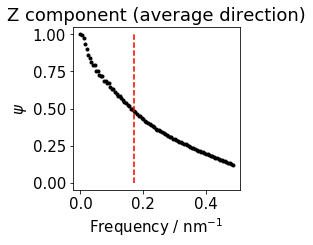

In [718]:
plt.figure(figsize=(3,3))
plt.plot(np.arange(98)*fpx,rats,'k.')
plt.plot([34*fpx,34*fpx],[0,1],'r--')
plt.xlabel(r'Frequency / nm$^{-1}$')
plt.ylabel(r'$\psi$')
plt.title('Z component (average direction)')

In [715]:
import scipy
import time

def opt_fun(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = data_completeness_ratio(shell_ind,crd,thresh=1)
    return abs(0.5-dc_ratio)

def opt_fun_dir(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = directional_completeness_ratio(crd,shell_ind,v=[1,-1,0])
    return abs(0.5-dc_ratio)

def opt_fun_vec(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = data_completeness_ratio_vec(shell_ind,crd,fz)
    return abs(0.5-dc_ratio)


ti = time.time()
# cons = (
#         {'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(len(x))])})
res = scipy.optimize.minimize(opt_fun_vec,30,method='Nelder-mead')
#res = scipy.optimize.differential_evolution(opt_fun, bounds=[(0,100)]) #global min 'guaranteed' but slower
tf = time.time()
print(tf-ti)

12.220093011856079


In [716]:
res

 final_simplex: (array([[ 34.5       ],
       [ 34.50009155]]), array([ 0.00014033,  0.00014033]))
           fun: 0.00014032685427112224
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 17
        status: 0
       success: True
             x: array([ 34.5])

In [717]:
34*fpx+2*fpx

0.18000000000000002

In [565]:
# add directionality

def directional_completeness_ratio(crd,shell_ind,v=[1,0,0],cone_angle=30):
    inside = []
    v = [1,-1,1]
    angs = []
    cone_angle = 30
    thresh = 1
    full,empty = 0,0
    for i in range(len(shell_ind[0])):
        ind = np.array(crd[shell_ind[0][i]])-100
        angle = np.arccos(np.dot(ind,v)/(np.linalg.norm(ind)*np.linalg.norm(v)))*180/np.pi
        #print(angle)
        angs.append(angle)
        if angle < cone_angle or angle > 180-cone_angle:
            #inside.append(ind)

            val = final[ind[0]+100,ind[1]+100,ind[2]+100]
            if val > thresh:
                full += 1
                inside.append(ind)
            else:
                empty += 1
    return full/(empty+full), inside

In [558]:
r,inside = directional_completeness_ratio(crd,shell_ind)

C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [559]:
r

0.013543031891655745

In [523]:
v = [1,0,0]
angle = np.arccos(np.dot(ind,v)/(np.linalg.norm(ind)*np.linalg.norm(v)))*180/np.pi
angle

57.558048132753122

In [521]:
np.shape(inside)

(0,)

In [270]:
crd = np.transpose(np.where(final)) # coordinates of points in volume
gsp = GriSPy(crd)

In [262]:
Ncentres = 1
dim = 3
Lbox=200
centres = np.random.uniform(0, Lbox, size=(Ncentres, dim))
centres

array([[   0.98563795,  148.13621919,  129.21151693]])

In [373]:
lower_radii = 40
upper_radii = lower_radii+1

centres = np.array([[100,100,100]])
shell_dist, shell_ind = gsp.shell_neighbors(
    centres,
    distance_lower_bound=lower_radii,
    distance_upper_bound=upper_radii
)

In [374]:
data_completeness_ratio(shell_ind,crd,thresh=.9)

0.6934436967784195

In [358]:
N = 200
d=100
n=100
rpx = d/n # real space pixel width
fpx = 1/rpx / N

40*fpx

0.2

In [343]:
def data_completeness_ratio(shell_ind,crd,thresh=1e-2):
    full = 0
    empty = 0
    final
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = final[ind[0],ind[1],ind[2]]
        #print(val)
        if val > thresh:
            full += 1
        else:
            empty += 1
    return full/(empty+full)

In [416]:
crd = np.transpose(np.where(final>-10))

In [410]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
inds = []
for i in range(len(shell_ind[0])):
    ind = crd[shell_ind[0][i]]
    inds.append(ind)
    ax.scatter(ind[0],ind[1],ind[2],color='dodgerblue',alpha=.5)
plt.show()

KeyboardInterrupt: 

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 432x288 with 1 Axes>

In [423]:
inds = []
for i in range(len(shell_ind[0])):
    ind = crd[shell_ind[0][i]]
    inds.append(ind)

In [407]:
np.shape(shell_ind[0])

(12846,)

In [405]:
plt.imshow(np.mean(shell_ind,axis=2))

IndexError: tuple index out of range

In [603]:
angles = multi_axis.generate_angles(n_tilt=20,mode='x')

In [674]:
def plot_slices3D_components(angles, d=100,n=100,lmin=1):
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, >10 is good enough
    # lmin is real space width of pixel at highest res of interest
    # d is width of image in nm
    # n is number of pixels across image in one row (assumed square)
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.gca()

    # Create uniform volume of ones
    vol = np.ones((n,n,n))
    
    # angle projection range
    
    # width of volume
    n = np.shape(vol)[1]
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width
    N = 200
    finalx = np.zeros((N,N,N))
    finaly = np.zeros((N,N,N))
    finalz = np.zeros((N,N,N))
    
    centre = int(N/2)
    
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
    width = 1/d # fourier space slice width
    width_i = width/fpx # number of fourier space pixels needed to represent slice width
    #print('--%.1f-- should be >=10, else your FS display resolution is not high enough)' % width_i)
    #print(int(width_i/2)*2,width_i)
    
    # project volume at each angle
    proj = multi_axis.generate_proj_data(vol,angles)
    proj = swap_cols(proj,1,0)
    
    print('projection finished')
    x = [1,0,0]
    y = [0,1,0]
    z = [0,0,1]
    
    # loop over angles and add each projection to fourier image
    for i,a in enumerate(angles):
        print(i)
        print('resizing')
        # get projected image
        p = proj[i].reshape((n,n,1))
        print(np.max(p))
        
        # calculate plane normal
        mrot = multi_axis.rotation_matrix(a[0],a[1],a[2])
        normal = np.dot(mrot,[0,0,1])
        
        # Calculate component weightings
        # when |normal x dir| is high, weighting is high
        # ie if e- direction is perp to component, it is sensitive to M
        comps = []
        for v in [x,y,z]:
            cross = (np.linalg.norm(normal)**2*np.linalg.norm(v)**2-np.dot(normal,v)**2)**.5
            comps.append(cross)

        # reshape projection to desired shape
        #p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
        p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d
        print(comps,a)
        fs = np.zeros((N,N,N))
        
        # central slice becomes projection data
        fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize
        
        # rotate to final position - this is quite slow - might be worth trying to speed up
        fsr = multi_axis.rotate_bulk(fs,a[0],a[1],a[2])
        #plt.imshow(fsr[100,:,:])
        #plt.show()
        print('fsr',np.max(fsr))
        
        finalx += fsr*comps[0]
        finalx = np.clip(finalx,0,1)
        finaly += fsr*comps[1]
        finaly = np.clip(finaly,0,1)
        finalz += fsr*comps[2]
        finalz = np.clip(finalz,0,1)
        
#         for j,f in enumerate([finalx,finaly,finalz]):
#             f += fsr*comps[j]
#             f = np.clip(f,0,1) # limit output max value to 1
#             print(j,np.max(f))
        
    return finalx,finaly,finalz

    #l

In [16]:
angles = multi_axis.generate_angles(n_tilt=40,mode='x')
fx,fy,fz = plot_slices3D_components(angles)

NameError: name 'multi_axis' is not defined

In [667]:
np.max(fx)

1.0

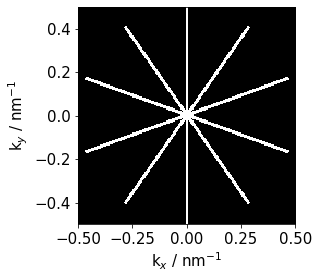

In [668]:
plot_3d_slices(fx,plane='yz')

Text(0.5, 1.0, 'Central yz - z component')

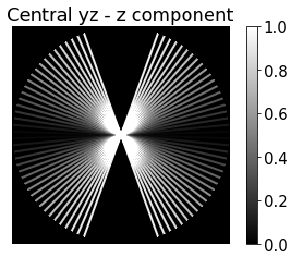

In [685]:
plt.imshow(fz[100,:,:].T,cmap='gray')
plt.colorbar()
plt.axis('off')
plt.title('Central yz - z component')

In [648]:
np.clip([0,0.1,0.2,-0.1,1,1.1],0,1)

array([ 0. ,  0.1,  0.2,  0. ,  1. ,  1. ])